In [1]:
# Imports
import os
import sys
import time
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from autosklearn.classification import AutoSklearnClassifier
p = os.path.abspath('..')
sys.path.insert(1, p)
from utils import add_to_autosklearn_pipeline
from notebook_utils import get_search_space_size

In [2]:
# Dataset
dataset = 'Cardiotocography'
data_iter = 1 # dataset iteration
# Import X_train, y_train, X_test, y_test
dataset_dir = '../data/processed/'+dataset+'/iter'+str(data_iter)+'/'
X_train = pd.read_csv(dataset_dir + 'X_train.csv')
y_train = pd.read_csv(dataset_dir + 'y_train.csv')
X_test = pd.read_csv(dataset_dir + 'X_test.csv')
y_test = pd.read_csv(dataset_dir + 'y_test.csv')

In [3]:
# PyOD classifiers
classifiers = [
    'CBLOFClassifier',
    'COPODClassifier',
    'IForestClassifier',
    'KNNClassifier',
    'LOFClassifier',
]
# Add classifiers to AutoSklearn pipeline
add_to_autosklearn_pipeline(classifiers)
# Create the search space
for clf in classifiers:
    print('{}: {}'.format(clf, get_search_space_size([clf])))
# Size of the total hyperparameter space
total_search_space = get_search_space_size(classifiers)
print('Total space size:', total_search_space)

CBLOFClassifier: 8800
COPODClassifier: 10
IForestClassifier: 6800
KNNClassifier: 2000
LOFClassifier: 2000
Total space size: 19610


In [4]:
# Budget estimation parameters
times = []
per_run_budget = 30
n_total = 100 # attempted runs
n_succeeded = 0 # succeeded runs
n_failed = 0 # failed runs
# Loop over total attempts
for i in tqdm(range(n_total)):
    # Sample a model
    idx = random.randint(0, len(classifiers)-1) # index
    model = classifiers[idx]
    # Create AutoSklearn classifier
    cls = AutoSklearnClassifier(
        time_left_for_this_task=per_run_budget,
        per_run_time_limit=per_run_budget,
        include={
            'classifier': [model]
        },
        delete_tmp_folder_after_terminate=False,
    )
    # Sample a configuration 
    cs = cls.get_configuration_space(X_train, y_train)
    config = cs.sample_configuration()
    # Fit the model[configuration]
    _, _, run_value = cls.fit_pipeline(
        X=X_train,
        y=y_train,
        config=config,
        X_test=X_test,
        y_test=y_test,
    )
    # Check success and store time
    if 'SUCCESS' in str(run_value[2]):
        times.append(run_value[1])
        n_succeeded += 1
    else:
        n_failed += 1
# Report successful vs failed runs
print('Runs attempted:\t\t\t', n_total)
print('Runs succeeded:\t\t\t', n_succeeded)
print('Runs failed:\t\t\t', n_failed)
print('Total time passed:\t\t', int(np.sum(times)))

100%|██████████| 100/100 [14:36<00:00,  8.77s/it]

Runs attempted:			 100
Runs succeeded:			 81
Runs failed:			 19
Total time passed:		 199


In [21]:
# Results
avg_time = round(np.average(times), 2)
std_time = round(np.std(times), 2)
conf_percentage = 0.01 # percentage of configurations to try
n_confs = int(total_search_space * conf_percentage) # configurations needed to run
alpha = 0 # 95% confidence
n_confs_budget = int(n_confs * (avg_time + alpha * std_time)) 
# Print statistics
print('Average run time per fit:\t\t\t', avg_time)
print('Standard deviation of the distribution:\t\t', std_time)
#print('Budget for {}% of configurations ({}):\t {}'.format(conf_percentage*100, n_confs, n_confs_budget))

Average run time per fit:			 2.46
Standard deviation of the distribution:		 3.18
Budget for 1.0% of configurations (196):	 482


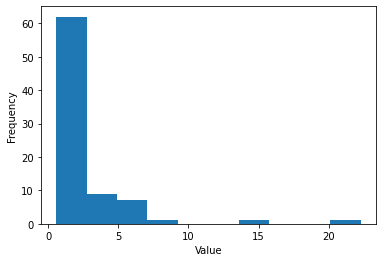

Shapiro-Wilk test results:
 ShapiroResult(statistic=0.563278317451477, pvalue=3.7675934014312976e-14)


In [6]:
# Distribution plot
from matplotlib import pyplot as plt
plt.hist(times, bins=10)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.savefig('t_hist.png')
plt.show()
# Shapiro-Wilk test for normality
from scipy import stats
shapiro_test = stats.shapiro(times)
print('Shapiro-Wilk test results:\n', shapiro_test)

In [12]:
# Save results to csv
df = pd.DataFrame(times, columns=['Times'])
pd.DataFrame.to_csv(df, 'times.csv')

,sumsquare_error,aic,bic,kl_div
gamma,0.257612,1522.565076,-452.627250,inf
lognorm,0.319151,985.172748,-435.276326,inf
burr,0.350051,987.358039,-423.396448,inf
beta,0.499728,1214.366841,-394.561529,inf
norm,2.071310,1599.247531,-288.178812,inf


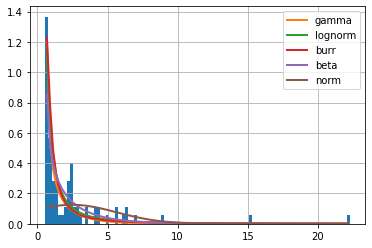

In [6]:
# Find the best fit distribution
from scipy.stats import gamma
from fitter import Fitter
if df is None:
    df = pd.read_csv('times.csv')
f = Fitter(df['Times'].values, distributions=['gamma', 'lognorm', "beta", "burr", "norm"])
f.fit()
f.summary()

In [19]:
# Calculate percentiles
p = 0.9 # coverage
# Distribution parameters
a = f.get_best(method = 'sumsquare_error')['gamma']['a']
loc = f.get_best(method = 'sumsquare_error')['gamma']['loc']
scale = f.get_best(method = 'sumsquare_error')['gamma']['scale']
x = gamma.ppf(p, a, loc, scale)
print('Percentile {}%: {}'.format(p * 100, x))
n_confs = 200 # set if not set prior
print('Estimated budget for 1% of configurations:', x * n_confs)

Percentile 90.0%: 2.837117118226642
Estimated budget for 1% of configurations: 567.4234236453284
